In [52]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import matplotlib
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
import xesmf as xe
import cftime
from glob import glob
import cmocean

phosphorus_molar_weight = 30.9
seconds_per_year = 24*60*60*365

## Generate paths

In [54]:
# pp path
pp_path = '/archive/jyl/fre/ESM45/ESM45_COBALTv3_20250224/ESM4.5v02cobv3_piC/gfdl.ncrc5-intel23-prod-openmp/pp/'
#pp_path = '/archive/jyl/fre/OM4_05/pull_requests/2025_02/OM4_05_COBALTv3_jra55_const/gfdl.ncrc5-intel23-prod/pp/'

In [55]:
grid_file = pp_path + 'ocean_annual/ocean_annual.static.nc'
grid = xr.open_dataset(grid_file)

In [56]:
# phosphorus vertical integral 
diag_type = 'ocean_cobalt_tracers_instant'
variable = 'wc_vert_int_p'

total_vertint_files = glob(pp_path + diag_type + '/ts/annual/5yr/' + diag_type + '*' + variable + '.nc')
#print(total_vertint_files)

In [57]:
# phosphorus budget files
# surface fluxes
diag_type = 'ocean_cobalt_sfc'
variables = ['runoff_flux_po4','runoff_flux_ldop','runoff_flux_sldop','runoff_flux_srdop','runoff_flux_pdet',\
             'dep_dry_po4','dep_wet_po4']

surf_files = [glob(pp_path + diag_type + '/ts/annual/5yr/' + diag_type + '*' + v + '.nc') for v in variables]
surf_files = sorted([f for fi in surf_files for f in fi]) # nested list comprehension
#print(surf_files)

In [58]:
# phosphorus budget files
diag_type = 'ocean_cobalt_fluxes_int'
variables = ['wc_vert_int_jpo4_iceberg']

flux_vertint_files = [glob(pp_path + diag_type + '/ts/annual/5yr/' + diag_type + '*' + v + '.nc') for v in variables]
flux_vertint_files = sorted([f for fi in flux_vertint_files for f in fi]) # nested list comprehension

In [59]:
# phosphorus budget files
# bottom fluxes
diag_type = 'ocean_cobalt_btm'
variables = ['fp_burial','fpdet_burial']

btm_files = [glob(pp_path + diag_type + '/ts/annual/5yr/' + diag_type + '*' + v + '.nc') for v in variables]
btm_files = sorted([f for fi in btm_files for f in fi]) # nested list comprehension

## Read in files

In [60]:
total = xr.open_mfdataset(total_vertint_files, combine='by_coords')

In [61]:
flux = xr.open_mfdataset(flux_vertint_files, combine='by_coords')

In [62]:
surf = xr.open_mfdataset(surf_files, combine='by_coords')

In [63]:
btm = xr.open_mfdataset(btm_files, combine='by_coords')

## Compute Global Inventory

These values are from ocean_cobalt_tracer_instant and are written out at the end of the year

In [64]:
global_total = (total.wc_vert_int_p * grid.areacello).sum(dim=['xh','yh']) * phosphorus_molar_weight
global_total = global_total

Text(0.5, 1.0, 'Global phosphorus inventory (Pg)')

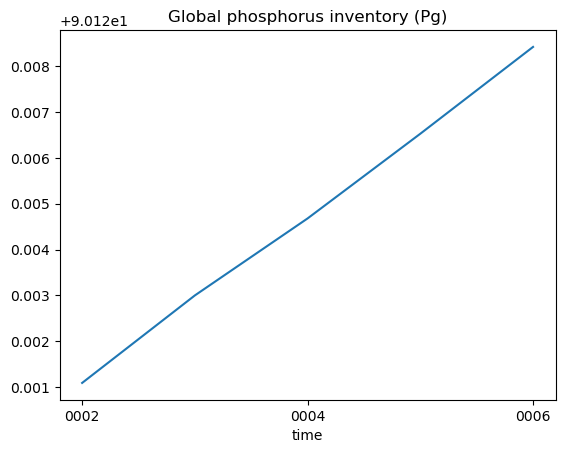

In [65]:
(global_total/1e15).plot()
#plt.ylim(37.94,37.948)
plt.title('Global phosphorus inventory (Pg)')

## Compute Fluxes

In [66]:
total_runoff = surf.runoff_flux_po4 + surf.runoff_flux_ldop + surf.runoff_flux_sldop + \
               surf.runoff_flux_srdop + surf.runoff_flux_pdet

total_runoff = (total_runoff * grid.areacello).sum(dim=['xh','yh'])
total_runoff = total_runoff * phosphorus_molar_weight * seconds_per_year

In [67]:
total_deposition = surf.dep_dry_po4 + surf.dep_wet_po4

total_deposition = (total_deposition * grid.areacello).sum(dim=['xh','yh'])
total_deposition = total_deposition * phosphorus_molar_weight * seconds_per_year

In [68]:
iceberg = (flux.wc_vert_int_jpo4_iceberg * grid.areacello).sum(dim=['xh','yh']) 
iceberg = iceberg * phosphorus_molar_weight * seconds_per_year

In [69]:
burial = (btm.fp_burial * grid.areacello).sum(dim=['xh','yh'])
#burial = (btm.fpdet_burial * grid.areacello).sum(dim=['xh','yh'])

burial = burial * phosphorus_molar_weight * seconds_per_year

Text(0.5, 1.0, 'Net phosphorus fluxes (grams)')

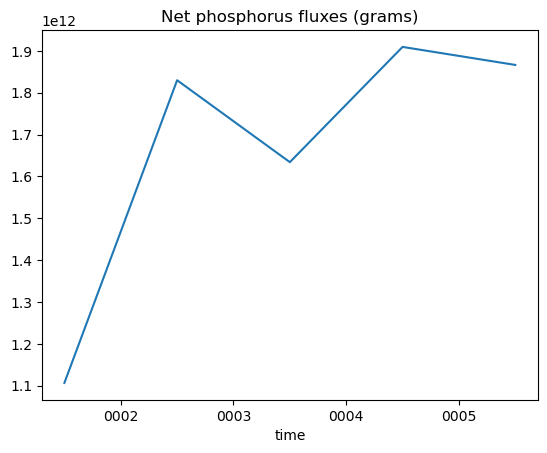

In [70]:
net_flux = total_runoff + total_deposition + iceberg - burial
net_flux.plot()
plt.title('Net phosphorus fluxes (grams)')

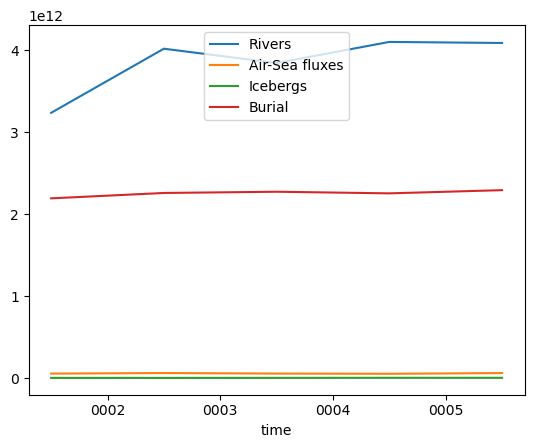

In [71]:
total_runoff.plot()
total_deposition.plot()
iceberg.plot()
burial.plot()
plt.legend(['Rivers','Air-Sea fluxes','Icebergs','Burial'])

## Close budgets
The total P inventory should be equal to the starting inventory plus the P fluxes
In this case we start with year 2 and onwards, because the wc_vert_int_p term is saved at the end of year 1

Text(0.5, 1.0, 'Phosphorus fluxes as calculated by the change in the global P inventory')

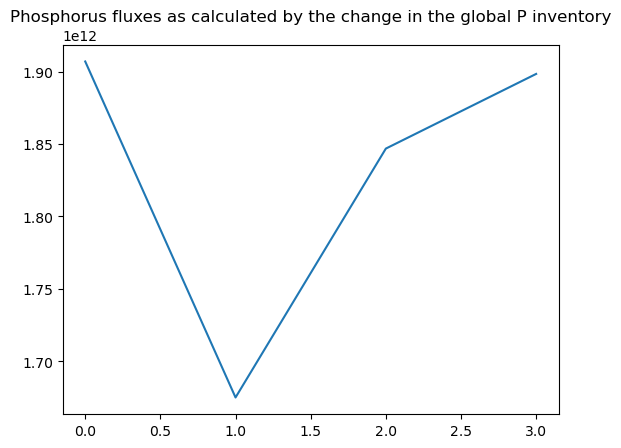

In [72]:
plt.plot(np.diff(global_total))
plt.title('Phosphorus fluxes as calculated by the change in the global P inventory')

In [73]:
np.diff(global_total.values)

array([1.9069655e+12, 1.6750372e+12, 1.8468359e+12, 1.8983755e+12],
      dtype=float32)

In [74]:
net_flux.values[1:]

array([1.82976968e+12, 1.63409172e+12, 1.90933203e+12, 1.86631233e+12])

Text(0.5, 1.0, 'Global phosphorus inventory (Pg)')

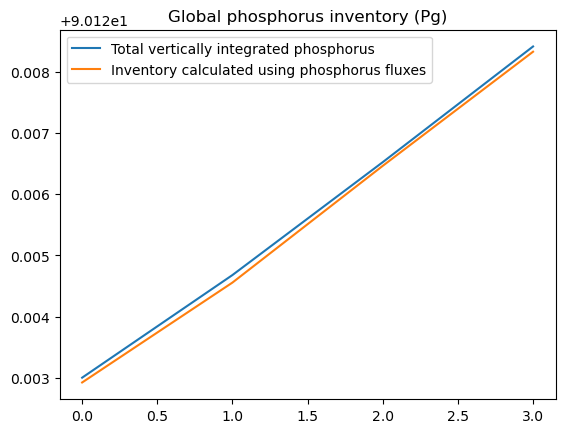

In [75]:
plt.plot(global_total.values[1:]/1e15)
plt.plot((np.cumsum(net_flux.values[1:])+global_total.values[0])/1e15)
plt.legend(['Total vertically integrated phosphorus','Inventory calculated using phosphorus fluxes'])
plt.title('Global phosphorus inventory (Pg)')

Text(0.5, 1.0, 'Total global phosphorus inventory imbalance')

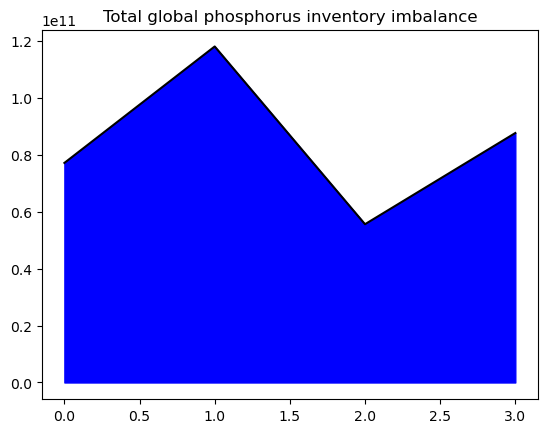

In [76]:
fig,ax = plt.subplots(1,1)
imbalance=(global_total.values[1:] - (np.cumsum(net_flux.values[1:])+global_total.values[0]))
plt.plot(imbalance, color='black')
ax.fill_between(np.arange(len(imbalance)), imbalance, where=imbalance>0, interpolate=True, color='blue')
ax.fill_between(np.arange(len(imbalance)), imbalance, where=imbalance<0, interpolate=True, color='red')
plt.title('Total global phosphorus inventory imbalance')

Text(0.5, 1.0, 'Total global phosphorus budget imbalance')

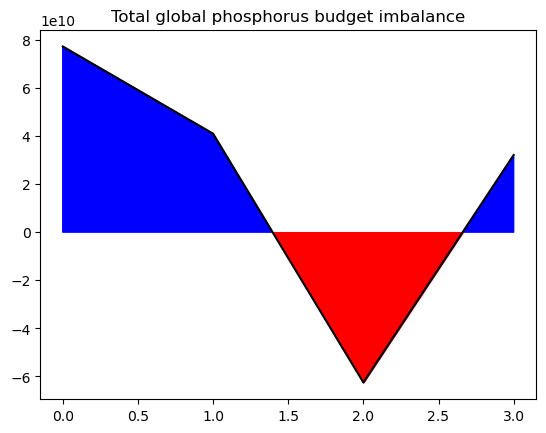

In [77]:
fig,ax = plt.subplots(1,1)
imbalance=(np.diff(global_total.values) - net_flux.values[1:])
plt.plot(imbalance, color='black')
ax.fill_between(np.arange(len(imbalance)), imbalance, where=imbalance>0, interpolate=True, color='blue')
ax.fill_between(np.arange(len(imbalance)), imbalance, where=imbalance<0, interpolate=True, color='red')
plt.title('Total global phosphorus budget imbalance')